In [1]:
# importing basic libraries
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from qiskit import *

# External imports
from pylab import cm
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.algorithms.optimizers import SPSA

from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data

from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel

import random
import time
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
# loading the dataset
df = pd.read_csv('dse_ft_data.csv')
df.head()

,Date,Price,Open,High,Low,gold,CE_rate,oil,Change %
0,2022-07-07,"6,366.95","6,364.07","6,386.49","6,360.75",1741.94,93.36,102.73,0.01%
1,2022-07-06,"6,366.05","6,384.20","6,400.41","6,360.97",1740.06,93.31,98.53,-0.10%
2,2022-07-05,"6,372.13","6,358.16","6,399.71","6,358.16",1769.48,93.36,99.50,0.40%
3,2022-07-04,"6,346.88","6,353.68","6,367.23","6,339.13",1809.16,93.40,110.40,-0.20%
4,2022-07-03,"6,359.77","6,381.49","6,387.24","6,352.58",NaN,NaN,108.19,-0.27%


In [3]:
# processing the dataset
df.drop(columns=['Date'], inplace=True)
for col in df.columns:
    if (col != 'Change %' and col != 'gold' and col != 'CE_rate' and col != 'oil'):
        df[col] = df[col].str.replace(',', '').astype('float')
    elif (col == 'Change %'):
        df[col] = df[col].str.rstrip('%').astype('float') / 100.0
        df[col] = np.where(df[col] <= 0.0, -1, 1)
df

,Price,Open,High,Low,gold,CE_rate,oil,Change %
0,6366.95,6364.07,6386.49,6360.75,1741.94,93.36,102.73,1
1,6366.05,6384.20,6400.41,6360.97,1740.06,93.31,98.53,-1
2,6372.13,6358.16,6399.71,6358.16,1769.48,93.36,99.50,1
3,6346.88,6353.68,6367.23,6339.13,1809.16,93.40,110.40,-1
4,6359.77,6381.49,6387.24,6352.58,NaN,NaN,108.19,-1
...,...,...,...,...,...,...,...,...
570,4228.36,4281.43,4317.66,4224.49,1557.89,84.60,59.61,-1
571,4281.43,4331.95,4348.33,4272.58,1595.24,84.60,62.70,-1
572,4331.95,4400.14,4414.44,4320.83,1563.83,84.60,63.27,-1
573,4400.14,4459.29,4465.04,4399.60,NaN,NaN,NaN,-1


In [4]:
# df.drop(columns=['Open', 'CE_rate', 'oil'], inplace=True)
df.dropna(inplace=True)
df

,Price,Open,High,Low,gold,CE_rate,oil,Change %
0,6366.95,6364.07,6386.49,6360.75,1741.94,93.36,102.73,1
1,6366.05,6384.20,6400.41,6360.97,1740.06,93.31,98.53,-1
2,6372.13,6358.16,6399.71,6358.16,1769.48,93.36,99.50,1
3,6346.88,6353.68,6367.23,6339.13,1809.16,93.40,110.40,-1
5,6376.94,6350.60,6387.86,6349.87,1806.67,93.45,105.76,1
...,...,...,...,...,...,...,...,...
569,4197.39,4228.36,4235.49,4187.48,1552.72,84.60,59.56,-1
570,4228.36,4281.43,4317.66,4224.49,1557.89,84.60,59.61,-1
571,4281.43,4331.95,4348.33,4272.58,1595.24,84.60,62.70,-1
572,4331.95,4400.14,4414.44,4320.83,1563.83,84.60,63.27,-1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462 entries, 0 to 574
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     462 non-null    float64
 1   Open      462 non-null    float64
 2   High      462 non-null    float64
 3   Low       462 non-null    float64
 4   gold      462 non-null    float64
 5   CE_rate   462 non-null    float64
 6   oil       462 non-null    float64
 7   Change %  462 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 32.5 KB


In [6]:
# Given the total size of the dataset, picks a random subsequence of the data
# and splits it into train and test set in 80-20 ratio
# returns x_train, x_test, y_train, y_test, starting point

def create_training_and_testing_data_sub(df_, DATA_SIZE_):
    data_size = DATA_SIZE_
    
    indices = np.random.choice(df.index, size=data_size, replace=False)
    subset_df = df.loc[indices]
    
    print(indices)
    
    # get the values from the last column of the subset and store them in y_subset
    y_subset = subset_df.iloc[:, -1].values

    # get the values from all other columns of the subset and store them in X_subset
    x_subset = subset_df.iloc[:, :-1].values

    # spltting the dataset into train and test set
    x_train, x_test, y_train, y_test = train_test_split(x_subset, y_subset, test_size = 0.2, random_state = 31)

    return x_train, x_test, y_train, y_test

In [7]:
# Saving Dataset

NUM_OF_EXPERIMENTS = int(input("Number of experiments to run: "))
DATA_SIZE = int(input("Size of dataset: "))
NUM_MAX_ITER = int(input("Number of max iterations: "))
data = []

for current_iter in range(NUM_OF_EXPERIMENTS):
    
    X_train, X_test, y_train, y_test = create_training_and_testing_data_sub(df, DATA_SIZE)
    
    data.append([X_train, X_test, y_train, y_test])


Number of experiments to run: 200
Size of dataset: 200
Number of max iterations: 1
[319  45 195 500 152 430 498 377 216 215 243 403 141 471  78 315 554  56
 265  46 488 184 107 225 179 190 181 525 267 477 559  39 110 200  52 440
  76 223 171  97 455  28  57   5 145 396 369  81 505 349 437 199 294 262
 385 441 211 302 286 264 292 118 113 162 296 450 400 434 344 546 508 459
  18 129 321 222  90 266 185 405 173 570 497 352 547  42 574 556 454 300
 221 186 364  40 355 358 260 376 325 245 147 445 329 453 353 537 517 102
 398 314  22 507 127 484 100  50 410 104 276 115 421 549 293 338 435 544
 381 495  83   3 463 447 241  99 148 482 541 472 342 229   8 202  75 340
 486 460 278  66 446 232 569  35 155 540 425  93 167 372 473 535 287 360
 444 124 228 532 406  41 120 108 255 390 242 166 328 103 303 143  51 522
 511 512 213 312 412 291  26  80 310 168 306 426 209 219 160 489 431  72
  94 305]
[121 236 260 293 390 452 180 194 440 114  37 476 526 347 436  46 126 461
 143 549 128 470 127 364 249 19

In [8]:
def find_classical_accuracy(x_train_, x_test_, y_train_, y_test_):
    
    svc_clf = svm.SVC(random_state = 7)
    svc_clf.fit(x_train_, y_train_)
    labels_pred = svc_clf.predict(x_test_)
    
    svc_accuracy = accuracy_score(y_test_, labels_pred)
    svc_score = metrics.balanced_accuracy_score(y_true=y_test_, y_pred=labels_pred)
    svc_f1_score = f1_score(y_test_, labels_pred)
    
    return svc_accuracy, svc_score, svc_f1_score

In [9]:
def find_classical_accuracy_dt(x_train_, x_test_, y_train_, y_test_):
    clf = DecisionTreeClassifier(random_state=42)

    # Train the classifier on the training data
    clf.fit(x_train_, y_train)

    # Make predictions on the testing data
    labels_pred = clf.predict(x_test_)
    
    svc_accuracy = accuracy_score(y_test_, labels_pred)
    svc_score = metrics.balanced_accuracy_score(y_true=y_test_, y_pred=labels_pred)
    svc_f1_score = f1_score(y_test_, labels_pred)
    
    return svc_accuracy, svc_score, svc_f1_score

In [10]:
def find_classical_accuracy_rf(x_train_, x_test_, y_train_, y_test_):
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the classifier on the training data
    rfc.fit(X_train, y_train)


    # Make predictions on the testing data
    labels_pred = rfc.predict(x_test_)
    
    svc_accuracy = accuracy_score(y_test_, labels_pred)
    svc_score = metrics.balanced_accuracy_score(y_true=y_test_, y_pred=labels_pred)
    svc_f1_score = f1_score(y_test_, labels_pred)
    
    return svc_accuracy, svc_score, svc_f1_score

In [11]:
svc_acc = []
svc_bacc = []
svc_f1_score = []
total_time_elapsed = 0

for current_iter in range(NUM_OF_EXPERIMENTS):
    
    print(f"Current experiment no: {current_iter}")
    
    X_train, X_test, y_train, y_test = data[current_iter][0], data[current_iter][1], data[current_iter][2], data[current_iter][3]
         
    accuracy_svm, balanced_accuracy_svm, classical_f1_score = find_classical_accuracy(X_train, X_test, y_train, y_test)
    svc_acc.append(accuracy_svm)
    svc_bacc.append(balanced_accuracy_svm)
    svc_f1_score.append(classical_f1_score)
    
    print(f"Accuracy, Balanced Accuracy and F1 Score Classical SVM: {accuracy_svm}, {balanced_accuracy_svm}, {classical_f1_score}")

    print(f"--------------------------------------------------------------------------------------------------------------------")

Current experiment no: 0
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.575, 0.5, 0.7301587301587301
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 1
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.55, 0.5, 0.7096774193548387
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 2
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.575, 0.5, 0.7301587301587301
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 3
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.5, 0.5, 0.6666666666666666
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 4
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.6, 0

Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.45, 0.5, 0.6206896551724138
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 40
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.525, 0.5, 0.6885245901639345
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 41
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.625, 0.5, 0.7692307692307693
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 42
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.55, 0.5, 0.7096774193548387
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 43
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.525, 0.5, 0.688524590163

Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.7, 0.5, 0.8235294117647058
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 139
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.6, 0.5, 0.7499999999999999
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 140
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.525, 0.5, 0.6885245901639345
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 141
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.55, 0.5, 0.7096774193548387
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 142
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.575, 0.5, 0.73015873015

Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.625, 0.5, 0.7692307692307693
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 181
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.525, 0.5, 0.6885245901639345
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 182
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.65, 0.5, 0.787878787878788
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 183
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.675, 0.5, 0.8059701492537313
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 184
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.625, 0.5, 0.76923076

In [12]:
print(svc_acc)
print("For Classical SVM:")
print("Mean Accuracy:       ", np.array(svc_acc).mean())
print("Standard deviation:  ", np.array(svc_acc).std())
print("Minimum Accuracy:    ", np.array(svc_acc).min())
print("Maximum Accuracy:    ", np.array(svc_acc).max())
svc_avg = np.array(svc_acc).mean()
svc_min = np.array(svc_acc).min()
svc_max = np.array(svc_acc).max()

[0.575, 0.55, 0.575, 0.5, 0.6, 0.625, 0.6, 0.675, 0.575, 0.675, 0.55, 0.6, 0.425, 0.625, 0.625, 0.575, 0.575, 0.5, 0.475, 0.575, 0.6, 0.65, 0.5, 0.65, 0.6, 0.625, 0.625, 0.625, 0.575, 0.55, 0.55, 0.6, 0.575, 0.525, 0.675, 0.575, 0.575, 0.575, 0.475, 0.45, 0.525, 0.625, 0.55, 0.525, 0.65, 0.5, 0.575, 0.675, 0.5, 0.625, 0.55, 0.65, 0.475, 0.65, 0.7, 0.625, 0.525, 0.55, 0.65, 0.725, 0.575, 0.575, 0.475, 0.55, 0.55, 0.65, 0.725, 0.7, 0.475, 0.475, 0.625, 0.6, 0.525, 0.6, 0.65, 0.6, 0.45, 0.55, 0.55, 0.5, 0.525, 0.575, 0.475, 0.6, 0.425, 0.55, 0.55, 0.625, 0.55, 0.575, 0.525, 0.6, 0.55, 0.55, 0.575, 0.575, 0.575, 0.5, 0.625, 0.575, 0.525, 0.575, 0.675, 0.575, 0.55, 0.625, 0.5, 0.675, 0.625, 0.575, 0.5, 0.675, 0.575, 0.475, 0.625, 0.5, 0.625, 0.475, 0.6, 0.575, 0.7, 0.6, 0.625, 0.6, 0.675, 0.625, 0.525, 0.6, 0.5, 0.55, 0.6, 0.525, 0.55, 0.65, 0.625, 0.55, 0.675, 0.575, 0.7, 0.6, 0.525, 0.55, 0.575, 0.6, 0.55, 0.475, 0.625, 0.725, 0.55, 0.6, 0.55, 0.525, 0.5, 0.575, 0.425, 0.5, 0.65, 0.675, 0

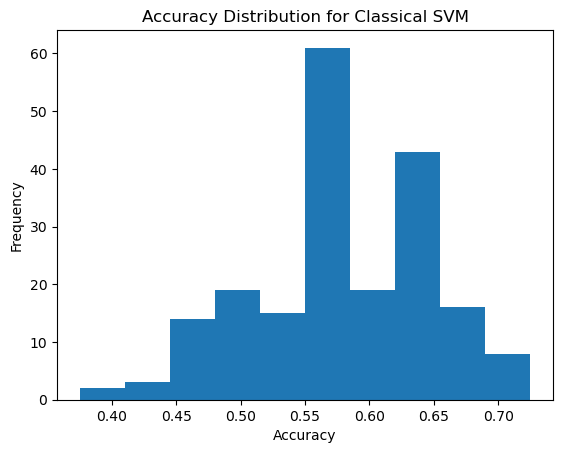

In [13]:
plt.hist(np.array(svc_acc))
plt.title('Accuracy Distribution for Classical SVM')
plt.xlabel('Accuracy')
plt.ylabel('Frequency');

In [14]:
print(svc_bacc)
print("For Classical SVM:")
print("Mean Balanced Accuracy:       ", np.array(svc_bacc).mean())
print("Standard deviation:  ", np.array(svc_bacc).std())
print("Minimum Balanced Accuracy:    ", np.array(svc_bacc).min())
print("Maximum Balanced Accuracy:    ", np.array(svc_bacc).max())
svc_avg = np.array(svc_bacc).mean()
svc_min = np.array(svc_bacc).min()
svc_max = np.array(svc_bacc).max()

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.53125, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4498207885304659, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.47953964194373405, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6190476190476191, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.44780219780219777, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.45, 0.4807692307692308, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5025062656641603, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4578005115089514, 0.5, 0.4066666666666667, 0.5, 0.4012539184952978, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

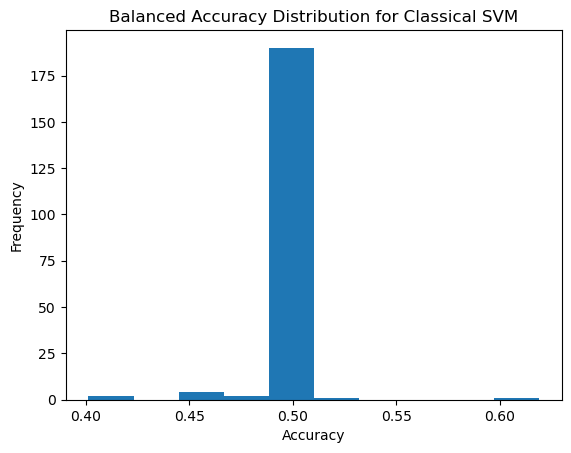

In [15]:
plt.hist(np.array(svc_bacc))
plt.title('Balanced Accuracy Distribution for Classical SVM')
plt.xlabel('Accuracy')
plt.ylabel('Frequency');

In [16]:
from sklearn.tree import DecisionTreeClassifier

svc_acc_dt = []
svc_bacc_dt = []
svc_f1_score_dt = []

for current_iter in range(NUM_OF_EXPERIMENTS):
    
    print(f"Current experiment no: {current_iter}")
    
    X_train, X_test, y_train, y_test = data[current_iter][0], data[current_iter][1], data[current_iter][2], data[current_iter][3]
        
    accuracy_svm, balanced_accuracy_svm, classical_f1_score = find_classical_accuracy_dt(X_train, X_test, y_train, y_test)
    svc_acc_dt.append(accuracy_svm)
    svc_bacc_dt.append(balanced_accuracy_svm)
    svc_f1_score_dt.append(classical_f1_score)
    
    print(f"Accuracy, Balanced Accuracy and F1 Score Classical SVM: {accuracy_svm}, {balanced_accuracy_svm}, {classical_f1_score}")

    print(f"--------------------------------------------------------------------------------------------------------------------")

Current experiment no: 0
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.65, 0.6265984654731458, 0.72
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 1
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.5, 0.5050505050505051, 0.5
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 2
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.525, 0.5179028132992327, 0.5777777777777778
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 3
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.6, 0.6, 0.6363636363636365
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 4
Accuracy, Balanced Accuracy and F1 Score Classic

Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.55, 0.521978021978022, 0.64
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 165
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.375, 0.38541666666666663, 0.358974358974359
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 166
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.55, 0.521978021978022, 0.64
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 167
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.75, 0.6951566951566952, 0.8214285714285715
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 168
Accuracy, Balanced Accuracy and F1 Score Classica

In [17]:
print(svc_acc_dt)
print("For Classical Decision Tree:")
print("Mean Accuracy:       ", np.array(svc_acc_dt).mean())
print("Standard deviation:  ", np.array(svc_acc_dt).std())
print("Minimum Accuracy:    ", np.array(svc_acc_dt).min())
print("Maximum Accuracy:    ", np.array(svc_acc_dt).max())
svc_avg = np.array(svc_acc_dt).mean()
svc_min = np.array(svc_acc_dt).min()
svc_max = np.array(svc_acc_dt).max()

[0.65, 0.5, 0.525, 0.6, 0.625, 0.6, 0.575, 0.55, 0.65, 0.525, 0.4, 0.5, 0.425, 0.45, 0.65, 0.575, 0.525, 0.475, 0.4, 0.45, 0.6, 0.6, 0.525, 0.575, 0.4, 0.525, 0.55, 0.575, 0.75, 0.45, 0.725, 0.625, 0.375, 0.525, 0.5, 0.675, 0.65, 0.7, 0.55, 0.45, 0.475, 0.575, 0.625, 0.5, 0.575, 0.5, 0.45, 0.525, 0.5, 0.675, 0.5, 0.625, 0.475, 0.475, 0.625, 0.575, 0.6, 0.575, 0.525, 0.575, 0.5, 0.675, 0.55, 0.475, 0.475, 0.525, 0.525, 0.525, 0.525, 0.55, 0.575, 0.35, 0.55, 0.625, 0.65, 0.525, 0.575, 0.625, 0.475, 0.55, 0.375, 0.475, 0.55, 0.475, 0.55, 0.475, 0.525, 0.55, 0.5, 0.6, 0.675, 0.6, 0.625, 0.575, 0.625, 0.575, 0.5, 0.625, 0.55, 0.625, 0.7, 0.475, 0.65, 0.625, 0.525, 0.475, 0.45, 0.525, 0.575, 0.675, 0.55, 0.525, 0.525, 0.6, 0.5, 0.575, 0.65, 0.525, 0.6, 0.525, 0.575, 0.575, 0.55, 0.5, 0.625, 0.6, 0.6, 0.525, 0.6, 0.475, 0.45, 0.5, 0.625, 0.5, 0.45, 0.625, 0.425, 0.55, 0.425, 0.6, 0.55, 0.55, 0.55, 0.475, 0.575, 0.575, 0.725, 0.35, 0.45, 0.55, 0.625, 0.4, 0.625, 0.45, 0.55, 0.55, 0.475, 0.575,

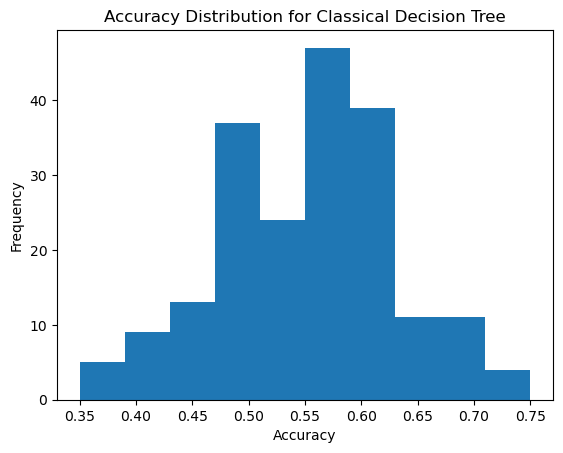

In [18]:
plt.hist(np.array(svc_acc_dt))
plt.title('Accuracy Distribution for Classical Decision Tree')
plt.xlabel('Accuracy')
plt.ylabel('Frequency');

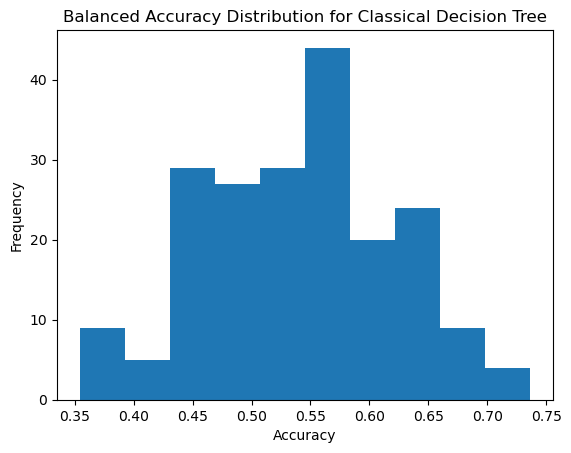

In [19]:
plt.hist(np.array(svc_bacc_dt))
plt.title('Balanced Accuracy Distribution for Classical Decision Tree')
plt.xlabel('Accuracy')
plt.ylabel('Frequency');

In [20]:
from sklearn.ensemble import RandomForestClassifier

svc_acc_rf = []
svc_bacc_rf = []
svc_f1_score_rf = []
total_time_elapsed = 0

for current_iter in range(NUM_OF_EXPERIMENTS):
    
    print(f"Current experiment no: {current_iter}")
    
    X_train, X_test, y_train, y_test = data[current_iter][0], data[current_iter][1], data[current_iter][2], data[current_iter][3]
     
    accuracy_svm, balanced_accuracy_svm, classical_f1_score = find_classical_accuracy_rf(X_train, X_test, y_train, y_test)
    svc_acc_rf.append(accuracy_svm)
    svc_bacc_rf.append(balanced_accuracy_svm)
    svc_f1_score_rf.append(classical_f1_score)
    
    print(f"Accuracy, Balanced Accuracy and F1 Score Classical SVM: {accuracy_svm}, {balanced_accuracy_svm}, {classical_f1_score}")

    print(f"--------------------------------------------------------------------------------------------------------------------")

Current experiment no: 0
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.6, 0.5907928388746804, 0.6521739130434783
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 1
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.55, 0.5454545454545454, 0.5909090909090909
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 2
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.675, 0.6560102301790282, 0.7346938775510203
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 3
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.55, 0.55, 0.608695652173913
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 4
Accuracy, Balanced

Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.65, 0.6342710997442456, 0.7083333333333334
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 36
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.525, 0.510230179028133, 0.5957446808510638
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 37
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.725, 0.6648745519713262, 0.8135593220338982
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 38
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.5, 0.5012531328320802, 0.5
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 39
Accuracy, Balanced Accuracy and F1 Scor

Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.55, 0.5208333333333333, 0.64
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 72
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.5, 0.493734335839599, 0.5652173913043478
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 73
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.5, 0.4583333333333333, 0.6153846153846153
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 74
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.65, 0.5989010989010989, 0.7407407407407408
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 75
Accuracy, Balanced Accuracy and F1 Score 

Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.65, 0.7008547008547008, 0.6818181818181819
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 108
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.65, 0.6266666666666667, 0.72
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 109
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.45, 0.42966751918158563, 0.5416666666666667
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 110
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.475, 0.475, 0.5333333333333332
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 111
Accuracy, Balanced Accuracy and F1 Score Clas

Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.5, 0.4583333333333333, 0.6153846153846153
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 144
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.525, 0.48737373737373735, 0.6666666666666666
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 145
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.425, 0.4398496240601504, 0.5490196078431372
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 146
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.625, 0.5800000000000001, 0.7169811320754718
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 147
Accuracy, Balance

Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.625, 0.54, 0.7457627118644068
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 180
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.5, 0.48000000000000004, 0.5833333333333334
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 181
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.5, 0.493734335839599, 0.5652173913043478
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 182
Accuracy, Balanced Accuracy and F1 Score Classical SVM: 0.55, 0.554945054945055, 0.608695652173913
--------------------------------------------------------------------------------------------------------------------
Current experiment no: 183
Accuracy, Balanced Accuracy and F1 Sc

In [21]:
print(svc_acc_rf)
print("For Classical SVM:")
print("Mean Accuracy:       ", np.array(svc_acc_rf).mean())
print("Standard deviation:  ", np.array(svc_acc_rf).std())
print("Minimum Accuracy:    ", np.array(svc_acc_rf).min())
print("Maximum Accuracy:    ", np.array(svc_acc_rf).max())
svc_avg = np.array(svc_acc_rf).mean()
svc_min = np.array(svc_acc_rf).min()
svc_max = np.array(svc_acc_rf).max()

[0.6, 0.55, 0.675, 0.55, 0.6, 0.625, 0.45, 0.525, 0.675, 0.55, 0.625, 0.475, 0.45, 0.45, 0.5, 0.65, 0.6, 0.575, 0.375, 0.475, 0.6, 0.55, 0.6, 0.5, 0.5, 0.725, 0.45, 0.65, 0.7, 0.4, 0.6, 0.675, 0.55, 0.475, 0.525, 0.65, 0.525, 0.725, 0.5, 0.4, 0.575, 0.575, 0.525, 0.525, 0.6, 0.525, 0.525, 0.475, 0.65, 0.75, 0.525, 0.675, 0.525, 0.5, 0.65, 0.525, 0.475, 0.55, 0.575, 0.525, 0.475, 0.6, 0.525, 0.475, 0.5, 0.5, 0.6, 0.625, 0.5, 0.475, 0.475, 0.55, 0.5, 0.5, 0.65, 0.525, 0.625, 0.625, 0.55, 0.525, 0.45, 0.6, 0.425, 0.55, 0.45, 0.525, 0.575, 0.675, 0.475, 0.55, 0.675, 0.625, 0.575, 0.5, 0.625, 0.6, 0.575, 0.55, 0.65, 0.625, 0.6, 0.525, 0.575, 0.5, 0.625, 0.575, 0.425, 0.65, 0.65, 0.45, 0.475, 0.55, 0.425, 0.525, 0.5, 0.575, 0.6, 0.525, 0.525, 0.55, 0.65, 0.575, 0.575, 0.525, 0.65, 0.55, 0.575, 0.65, 0.6, 0.4, 0.475, 0.5, 0.725, 0.675, 0.475, 0.55, 0.525, 0.55, 0.6, 0.575, 0.525, 0.6, 0.675, 0.5, 0.525, 0.425, 0.625, 0.5, 0.45, 0.525, 0.475, 0.5, 0.65, 0.525, 0.575, 0.575, 0.55, 0.675, 0.575,

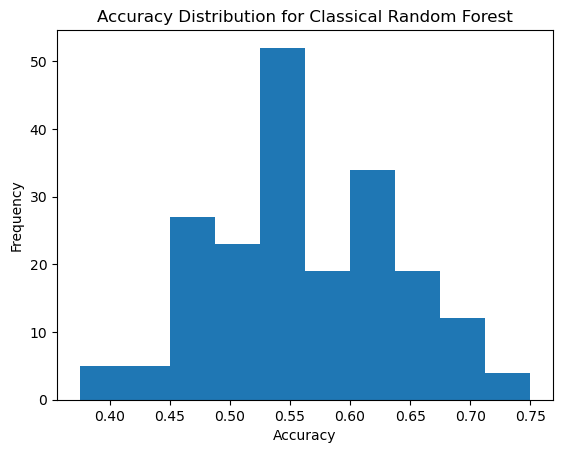

In [22]:
plt.hist(np.array(svc_acc_rf))
plt.title('Accuracy Distribution for Classical Random Forest')
plt.xlabel('Accuracy')
plt.ylabel('Frequency');

In [23]:
print(svc_bacc_rf)
print("For Classical Random Forest:")
print("Mean Balanced Accuracy:       ", np.array(svc_bacc_rf).mean())
print("Standard deviation:  ", np.array(svc_bacc_rf).std())
print("Minimum Balanced Accuracy:    ", np.array(svc_bacc_rf).min())
print("Maximum Balanced Accuracy:    ", np.array(svc_bacc_rf).max())
svc_avg = np.array(svc_bacc_rf).mean()
svc_min = np.array(svc_bacc_rf).min()
svc_max = np.array(svc_bacc_rf).max()

[0.5907928388746804, 0.5454545454545454, 0.6560102301790282, 0.55, 0.59375, 0.6066666666666667, 0.4270833333333333, 0.4686609686609687, 0.6867007672634271, 0.5270655270655271, 0.6035353535353536, 0.46875, 0.47570332480818417, 0.44, 0.4666666666666667, 0.6342710997442456, 0.5524296675191815, 0.575, 0.36716791979949875, 0.45140664961636834, 0.5625, 0.4560439560439561, 0.6, 0.48351648351648346, 0.4583333333333333, 0.71875, 0.42666666666666664, 0.6000000000000001, 0.6547314578005116, 0.3737373737373737, 0.5858585858585859, 0.6666666666666667, 0.5242966751918159, 0.47744360902255634, 0.5284900284900285, 0.6342710997442456, 0.510230179028133, 0.6648745519713262, 0.5012531328320802, 0.40909090909090906, 0.5776942355889725, 0.48666666666666664, 0.5126262626262627, 0.5200501253132832, 0.5604395604395604, 0.525, 0.5025575447570333, 0.47150997150997154, 0.7023809523809523, 0.76, 0.5126262626262627, 0.6016483516483516, 0.5350877192982456, 0.46703296703296704, 0.6309523809523809, 0.4599999999999999

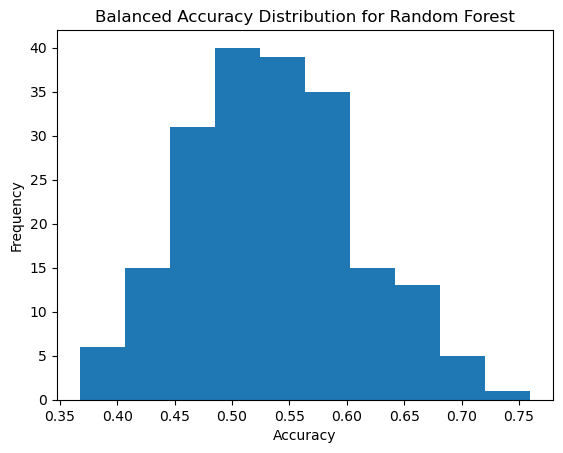

In [24]:
plt.hist(np.array(svc_bacc_rf))
plt.title('Balanced Accuracy Distribution for Random Forest')
plt.xlabel('Accuracy')
plt.ylabel('Frequency');

In [25]:
def find_closest_to_mean(arr):
    mean = sum(arr) / len(arr)  # Calculate mean of the list

    # Calculate the differences between each element and the mean, and store them in a tuple with their index
    diff_indices = [(abs(x - mean), i) for i, x in enumerate(arr)]

    # Sort the tuple by the difference values
    sorted_diff_indices = sorted(diff_indices)

    # Extract the indices of the two closest values
    index1 = sorted_diff_indices[0][1]
    index2 = sorted_diff_indices[1][1]
    return [index1, index2]

In [26]:
def find_closest_to_max(arr):
    max_val = max(arr)  # Calculate max of the list

    # Calculate the differences between each element and the max, and store them in a tuple with their index
    diff_indices = [(abs(x - max_val), i) for i, x in enumerate(arr)]

    # Sort the tuple by the difference values
    sorted_diff_indices = sorted(diff_indices)

    # Extract the indices of the two closest values
    index1 = sorted_diff_indices[0][1]
    index2 = sorted_diff_indices[1][1]
    return [index1, index2]

In [27]:
def find_closest_to_min(arr):
    min_val = min(arr)  # Calculate min of the list

    # Calculate the differences between each element and the min, and store them in a tuple with their index
    diff_indices = [(abs(x - min_val), i) for i, x in enumerate(arr)]

    # Sort the tuple by the difference values
    sorted_diff_indices = sorted(diff_indices)

    # Extract the indices of the two closest values
    index1 = sorted_diff_indices[0][1]
    index2 = sorted_diff_indices[1][1]
    return [index1, index2]

In [28]:
fm_list = []
names_fm = []
def create_feature_maps(features_):
    feature_map = PauliFeatureMap(features_, reps=2, paulis=['Z'], entanglement="linear")
    fm_list.append(feature_map)
    names_fm.append('Z')
    feature_map = PauliFeatureMap(features_, reps=2, paulis=['ZZ'], entanglement="linear")
    fm_list.append(feature_map)
    names_fm.append('ZZ')
    feature_map = PauliFeatureMap(features_, reps=2, paulis=['YY'], entanglement="linear")
    fm_list.append(feature_map)
    names_fm.append('YY')
    feature_map = PauliFeatureMap(features_, reps=2, paulis=['Z', 'ZZ'], entanglement="linear")
    fm_list.append(feature_map)
    names_fm.append('Z ZZ')
    feature_map = PauliFeatureMap(features_, reps=2, paulis=['Y', 'YY'], entanglement="linear")
    fm_list.append(feature_map)
    names_fm.append('Y YY')
    feature_map = PauliFeatureMap(features_, reps=2, paulis=['X', 'YY'], entanglement="linear")
    fm_list.append(feature_map)
    names_fm.append('X YY')
    feature_map = PauliFeatureMap(features_, reps=2, paulis=['Z', 'YY'], entanglement="linear")
    fm_list.append(feature_map)
    names_fm.append('Z YY')
    feature_map = PauliFeatureMap(features_, reps=2, paulis=['Y', 'XY'], entanglement="linear")
    fm_list.append(feature_map)
    names_fm.append('Y XY')
    feature_map = PauliFeatureMap(features_, reps=2, paulis=['X', 'XY'], entanglement="linear")
    fm_list.append(feature_map)
    names_fm.append('X XY')
    feature_map = PauliFeatureMap(features_, reps=2, paulis=['Z', 'XY'], entanglement="linear")
    fm_list.append(feature_map)
    names_fm.append('Z XY')
    

In [29]:
create_feature_maps(7)

In [30]:
def train_and_fit_model(x_train_, x_test_, y_train_, y_test_, fm_):
    
    start = time.time()
    
    # Building Kernel
    dse_feature_map = fm_

    dse_backend = QuantumInstance(
        Aer.get_backend('qasm_simulator'), shots=1024, seed_simulator=12345, seed_transpiler=12345
    )

    dse_kernel = QuantumKernel(feature_map=dse_feature_map, quantum_instance=dse_backend)
    qsvc = QSVC(quantum_kernel=dse_kernel)
    qsvc.fit(x_train_, y_train_)
    
    # Predict the labels
    labels_test = qsvc.predict(x_test_)
    
    accuracy_test = metrics.accuracy_score(y_true=y_test_, y_pred=labels_test)
    ba_score = metrics.balanced_accuracy_score(y_true=y_test_, y_pred=labels_test)
    q_f1_score = f1_score(y_test_, labels_test)
    
    elapsed = time.time() - start
    
    return accuracy_test, ba_score, q_f1_score, elapsed

In [31]:
print("For Mean Performance: ")
indices_mean = find_closest_to_mean(svc_bacc)
print(indices_mean)

q_ba, q_a, q_f1 = [], [], []
svc_ba, svc_a, svc_f1 = [], [], []
dt_ba, dt_a, dt_f1 = [], [], []
rf_ba, rf_a, rf_f1 = [], [], []

for fm in fm_list:
    qba, qa, qf = [], [], []
    for idx in indices_mean:
        X_train, X_test, y_train, y_test = data[idx]
        acc, bacc, f1, elapsed = train_and_fit_model(X_train, X_test, y_train, y_test, fm)
        print(f"Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: {acc}, {bacc}, {f1}, {elapsed}")
        qba.append(bacc)
        qa.append(acc)
        qf.append(f1)
    q_ba.append(qba)
    q_a.append(qa)
    q_f1.append(qf)
    svc_ba.append(svc_bacc[idx])
    svc_a.append(svc_acc[idx])
    svc_f1.append(svc_f1_score[idx])
    dt_ba.append(svc_bacc_dt[idx])
    dt_a.append(svc_acc_dt[idx])
    dt_f1.append(svc_f1_score_dt[idx])
    rf_ba.append(svc_bacc_rf[idx])
    rf_a.append(svc_acc_rf[idx])
    rf_f1.append(svc_f1_score_rf[idx])

print("\n")
print(f"Averge Balanced Accuracy for SVM: {sum(svc_ba)/len(svc_ba)}")
print(f"Average Accuracy for SVM: {sum(svc_a)/len(svc_a)}")
print(f"Average F1 Score for SVM: {sum(svc_f1)/len(svc_f1)}")
print("\n");
print(f"Averge Balanced Accuracy for Decision Tree: {sum(dt_ba)/len(dt_ba)}")
print(f"Average Accuracy for Pauli Decision Tree: {sum(dt_a)/len(dt_a)}")
print(f"Average F1 Score for Pauli Decision Tree: {sum(dt_f1)/len(dt_f1)}")
print("\n");
print(f"Averge Balanced Accuracy for Random Forest: {sum(rf_ba)/len(rf_ba)}")
print(f"Average Accuracy for Pauli Random Forest: {sum(rf_a)/len(rf_a)}")
print(f"Average F1 Score for Pauli Random Forest: {sum(rf_f1)/len(rf_f1)}")
print("\n");
for i in range(len(fm_list)):
    print(f"Averge Balanced Accuracy for Pauli {names_fm[i]}: {sum(q_ba[i])/len(q_ba[i])}")
    print(f"Average Accuracy for Pauli {names_fm[i]}: {sum(q_a[i])/len(q_a[i])}")
    print(f"Average F1 Score for Pauli {names_fm[i]}: {sum(q_f1[i])/len(q_f1[i])}")
    print("\n")

For Mean Performance: 
[0, 1]
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.55, 0.5012787723785166, 0.6785714285714286, 33.12089705467224
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.525, 0.5075757575757576, 0.6122448979591836, 32.97795295715332
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.5, 0.4578005115089514, 0.6296296296296297, 50.426631927490234
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.55, 0.5303030303030303, 0.64, 53.93210506439209
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.55, 0.5089514066496164, 0.6666666666666667, 54.14264798164368
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.7, 0.696969696969697, 0.7272727272727273, 57.92200016975403
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.575, 0.5076726342710998, 0.721311475409836, 81.85970497131348
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.575, 0.5378787878787878, 0.7017543859649122, 97.28862404823303
Accuracy, Balanced Accuracy, F1 Score, Elapsed T

In [32]:
print("For Max Performance ")
indices_max = find_closest_to_max(svc_bacc)
print(indices_max)

q_ba, q_a, q_f1 = [], [], []
svc_ba, svc_a, svc_f1 = [], [], []
dt_ba, dt_a, dt_f1 = [], [], []
rf_ba, rf_a, rf_f1 = [], [], []

for fm in fm_list:
    qba, qa, qf = [], [], []
    for idx in indices_max:
        X_train, X_test, y_train, y_test = data[idx]
        acc, bacc, f1, elapsed = train_and_fit_model(X_train, X_test, y_train, y_test, fm)
        print(f"Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: {acc}, {bacc}, {f1}, {elapsed}")
        qba.append(bacc)
        qa.append(acc)
        qf.append(f1)
    q_ba.append(qba)
    q_a.append(qa)
    q_f1.append(qf)
    svc_ba.append(svc_bacc[idx])
    svc_a.append(svc_acc[idx])
    svc_f1.append(svc_f1_score[idx])
    dt_ba.append(svc_bacc_dt[idx])
    dt_a.append(svc_acc_dt[idx])
    dt_f1.append(svc_f1_score_dt[idx])
    rf_ba.append(svc_bacc_rf[idx])
    rf_a.append(svc_acc_rf[idx])
    rf_f1.append(svc_f1_score_rf[idx])

print("\n")
print(f"Averge Balanced Accuracy for SVM: {sum(svc_ba)/len(svc_ba)}")
print(f"Average Accuracy for SVM: {sum(svc_a)/len(svc_a)}")
print(f"Average F1 Score for SVM: {sum(svc_f1)/len(svc_f1)}")
print("\n");
print(f"Averge Balanced Accuracy for Decision Tree: {sum(dt_ba)/len(dt_ba)}")
print(f"Average Accuracy for Pauli Decision Tree: {sum(dt_a)/len(dt_a)}")
print(f"Average F1 Score for Pauli Decision Tree: {sum(dt_f1)/len(dt_f1)}")
print("\n");
print(f"Averge Balanced Accuracy for Random Forest: {sum(rf_ba)/len(rf_ba)}")
print(f"Average Accuracy for Pauli Random Forest: {sum(rf_a)/len(rf_a)}")
print(f"Average F1 Score for Pauli Random Forest: {sum(rf_f1)/len(rf_f1)}")
print("\n");
for i in range(len(fm_list)):
    print(f"Averge Balanced Accuracy for Pauli {names_fm[i]}: {sum(q_ba[i])/len(q_ba[i])}")
    print(f"Average Accuracy for Pauli {names_fm[i]}: {sum(q_a[i])/len(q_a[i])}")
    print(f"Average F1 Score for Pauli {names_fm[i]}: {sum(q_f1[i])/len(q_f1[i])}")
    print("\n")

For Max Performance 
[67, 25]
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.65, 0.5833333333333334, 0.75, 53.98864006996155
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.625, 0.6354166666666667, 0.6511627906976745, 55.46505284309387
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.45, 0.34523809523809523, 0.6071428571428571, 74.00593876838684
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.65, 0.625, 0.7199999999999999, 71.45787620544434
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.675, 0.6011904761904762, 0.7719298245614034, 71.04582905769348
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.525, 0.5, 0.6122448979591836, 85.76619482040405
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.625, 0.44642857142857145, 0.7692307692307693, 106.43370699882507
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.525, 0.4479166666666667, 0.6779661016949152, 101.2090368270874
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.675, 0.601190

In [33]:
print("For Min Performance ")
indices_min = find_closest_to_min(svc_bacc)
print(indices_min)

q_ba, q_a, q_f1 = [], [], []
svc_ba, svc_a, svc_f1 = [], [], []
dt_ba, dt_a, dt_f1 = [], [], []
rf_ba, rf_a, rf_f1 = [], [], []

for fm in fm_list:
    qba, qa, qf = [], [], []
    for idx in indices_min:
        X_train, X_test, y_train, y_test = data[idx]
        acc, bacc, f1, elapsed = train_and_fit_model(X_train, X_test, y_train, y_test, fm)
        print(f"Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: {acc}, {bacc}, {f1}, {elapsed}")
        qba.append(bacc)
        qa.append(acc)
        qf.append(f1)
    q_ba.append(qba)
    q_a.append(qa)
    q_f1.append(qf)
    svc_ba.append(svc_bacc[idx])
    svc_a.append(svc_acc[idx])
    svc_f1.append(svc_f1_score[idx])
    dt_ba.append(svc_bacc_dt[idx])
    dt_a.append(svc_acc_dt[idx])
    dt_f1.append(svc_f1_score_dt[idx])
    rf_ba.append(svc_bacc_rf[idx])
    rf_a.append(svc_acc_rf[idx])
    rf_f1.append(svc_f1_score_rf[idx])

print("\n")
print(f"Averge Balanced Accuracy for SVM: {sum(svc_ba)/len(svc_ba)}")
print(f"Average Accuracy for SVM: {sum(svc_a)/len(svc_a)}")
print(f"Average F1 Score for SVM: {sum(svc_f1)/len(svc_f1)}")
print("\n");
print(f"Averge Balanced Accuracy for Decision Tree: {sum(dt_ba)/len(dt_ba)}")
print(f"Average Accuracy for Pauli Decision Tree: {sum(dt_a)/len(dt_a)}")
print(f"Average F1 Score for Pauli Decision Tree: {sum(dt_f1)/len(dt_f1)}")
print("\n");
print(f"Averge Balanced Accuracy for Random Forest: {sum(rf_ba)/len(rf_ba)}")
print(f"Average Accuracy for Pauli Random Forest: {sum(rf_a)/len(rf_a)}")
print(f"Average F1 Score for Pauli Random Forest: {sum(rf_f1)/len(rf_f1)}")
print("\n");
for i in range(len(fm_list)):
    print(f"Averge Balanced Accuracy for Pauli {names_fm[i]}: {sum(q_ba[i])/len(q_ba[i])}")
    print(f"Average Accuracy for Pauli {names_fm[i]}: {sum(q_a[i])/len(q_a[i])}")
    print(f"Average F1 Score for Pauli {names_fm[i]}: {sum(q_f1[i])/len(q_f1[i])}")
    print("\n")

For Min Performance 
[163, 161]
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.625, 0.5721003134796239, 0.7272727272727274, 81.3773980140686
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.625, 0.6066666666666667, 0.6938775510204083, 81.26846837997437
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.65, 0.64576802507837, 0.7307692307692308, 106.57546496391296
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.5, 0.42666666666666664, 0.6428571428571428, 113.52933096885681
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.725, 0.6410658307210031, 0.8135593220338982, 119.54203081130981
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.65, 0.6000000000000001, 0.7407407407407408, 122.81713604927063
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.625, 0.5156739811912225, 0.7457627118644068, 125.52717900276184
Accuracy, Balanced Accuracy, F1 Score, Elapsed Time: 0.625, 0.5266666666666667, 0.7540983606557377, 141.4097616672516
Accuracy, Balanced Accura